TODO:
- calculate TOTAL, TOTAL2, TOTAL3 correctly
- join Macro data

In [1]:
import sys
from pathlib import Path

# Add project root to sys.path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [2]:
import json
import ccxt
import requests
import numpy as np
import pandas as pd
import duckdb
import pandas_datareader.data as web
from requests import Request, Session
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import get_project_root

In [3]:
get_project_root()

PosixPath('/home/karsti11/dev/playground/tiny_hedge_fund')

In [4]:
CMC_APIKEY = '422d278b-26b5-446b-ae35-b4efa640fe7a' 
# Set date range 
START_DATE = datetime(1990, 1, 1)
END_DATE = datetime.now().date()
TODAYS_DATE_STR = datetime.now().date().strftime('%d%m%Y')
PROJECT_ROOT = get_project_root()
RAW_DATA_FOLDER = PROJECT_ROOT / 'data/raw'

SYMBOLS_TO_CORRECT = {'HYPE': 'HYPE32196', 'UNI': 'UNI1', 'TRUMP':'TRUMP-OFFICIAL', 'SUI': 'SUI20947', 'APT': 'APT21794'}
INDEXES = {
    's_p_500': '^GSPC', 'nasdaq': '^IXIC', 'dow_jones': '^DJI', 'ftse_100': '^FTSE', 'dax': '^GDAXI', 
    'cac_40': '^FCHI', 'nikkei_225': '^N225', 'shanghai_composite': '^SSEC', 'moex_russia': '^IMOEX', 
    's_p_tsx_composite': '^GSPTSE', 'bse_sensex': '^BSESN', 'asx_200': '^AXJO'
          }
COMMODITIES = {'gold': 'GC=F', 'silver': 'SI=F', 'copper': 'HG=F', 'oil': 'CL=F', 'natural_gas': 'NG=F'}

In [5]:
class MacroDataGetter:
    def __init__(self, start_date, end_date, commodities):
        self.start_date = start_date
        self.end_date = end_date
        self.commodities = commodities

    def fetch_all_data(self):
        self.fed_rates()
        self.us_gdp()
        self.unemployments()
        self.us_cpi()
        self.treasury_yields()
        self.treasury_bonds()
        self.commodities_data()

    def merge_macro(self):
        self.macro_data = self.fed_rates.join(
            self.us_gdp, how='left').join(
            self.us_unemp, how='left').join(
            self.eu_unemp, how='left').join(
            self.us_cpi, how='left')
        self.treasury_yields = self.treasury_2y.join(
            self.treasury_10y, how='left')

    def save_all_macro_data(self, raw_data_folder):
        try:
            self.macro_data.to_parquet(raw_data_folder / f'macros_{TODAYS_DATE_STR}.parquet')
            self.treasury_yields.to_parquet(raw_data_folder / f'treasury_yields_{TODAYS_DATE_STR}.parquet')
            self.treasury_bonds.to_parquet(raw_data_folder / f'treasury_bonds_{TODAYS_DATE_STR}.parquet')
            self.commodities_df.to_parquet(raw_data_folder / f'commodities_{TODAYS_DATE_STR}.parquet')
        except Exception as e:
                print(f"Error saving all macro data: {e}")
    
    def fed_rates(self):
        # Monthly interest rates
        self.fed_rates = web.DataReader(
            'FEDFUNDS', 'fred', self.start_date, self.end_date
        ).rename(
            columns={'FEDFUNDS': 'fed_rates'}
        )
    def us_gdp(self):
        # Quarterly US GDP
        self.us_gdp = web.DataReader(
            'GDP', 'fred', self.start_date, self.end_date
        ).rename(
            columns={'GDP': 'us_gdp'}
        )
    def unemployments(self):
        # Monthly unemployment rates
        self.us_unemp = web.DataReader(
            'UNRATE', 'fred', self.start_date, self.end_date
        ).rename(
            columns={'UNRATE': 'us_unemployment_rate'}
        )
        self.eu_unemp = web.DataReader(
            'LRHUTTTTEZM156S', 'fred', self.start_date, self.end_date
        ).rename(
            columns={'LRHUTTTTEZM156S': 'eu_unemployment_rate'}
        )  # Euro Area
    def us_cpi(self):
        # Monthly US CPI data
        self.us_cpi = web.DataReader(
            'CPIAUCSL', 'fred', self.start_date, self.end_date
        ).rename(
            columns={'CPIAUCSL': 'us_cpi'}
        )
    def treasury_yields(self):
        # Daily treasury yield rates
        self.treasury_2y = web.DataReader(
            'DGS2', 'fred', self.start_date, self.end_date
        ).rename(
            columns={'DGS2': 'treasury_2y'}
        )
        self.treasury_10y = web.DataReader(
            'DGS10', 'fred', self.start_date, self.end_date
        ).rename(
            columns={'DGS10': 'treasury_10y'}
        )
    def treasury_bonds(self):
        # Daily treasury bonds prices
        self.treasury_bonds = yf.download(
            'TLT', start=self.start_date, end=self.end_date
        ).rename(
            columns={'TLT': 'treasury_bonds'}
        )
    def commodities_data(self):
        # Daily commodities
        self.commodities_df = pd.DataFrame()
        for name, ticker in self.commodities.items():
            try:
                # Download data using yfinance
                commodity_df = yf.download(ticker, start=self.start_date, end=self.end_date, interval="1d")
                if not commodity_df.empty:
                    commodity_df.columns = [x.lower() for x in commodity_df.columns.get_level_values(0)]
                    commodity_df['commodity'] = name
                    self.commodities_df = pd.concat([self.commodities_df, commodity_df], axis=0)
                    print(f"Successfully fetched data for {name}")
                else:
                    print(f"No data returned for {name}")
            except Exception as e:
                print(f"Error fetching data for {name}: {e}")


class StockMarketData:
    def __init__(
        self,
        start_date,
        end_date,
        market_indexes
    ):
        self.start_date = start_date
        self.end_date = end_date
        self.market_indexes = market_indexes

    def load_market_indexes(self):
        self.market_indexes_df = pd.DataFrame()
        for name, ticker in self.market_indexes.items():
            try:
                # Download data using yfinance
                index_df = yf.download(ticker, start=self.start_date, end=self.end_date, interval="1d")
                if not index_df.empty:
                    index_df.columns = [x.lower() for x in index_df.columns.get_level_values(0)]
                    index_df['market_index'] = name
                    self.market_indexes_df = pd.concat([self.market_indexes_df, index_df], axis=0)
                    print(f"Successfully fetched data for {name}")
                else:
                    print(f"No data returned for {name}")
            except Exception as e:
                print(f"Error fetching data for {name}: {e}")
                
    def save_data(self, raw_data_folder):
        try:
            self.market_indexes_df.to_parquet(raw_data_folder / f'stock_market_indexes_{TODAYS_DATE_STR}.parquet')
        except Exception as e:
                print(f"Error saving all macro data: {e}")
        
class CryptoData:
    def __init__(
        self, 
        api_key, 
        start_date, 
        end_date,
        top_cryptos_num,
        ohlcv_cols
    ):
        self.api_key = api_key
        self.start_date = start_date
        self.end_date = end_date
        self.top_cryptos_num = top_cryptos_num
        self.ohlcv_cols = ohlcv_cols
        self.ohlc_cols = ohlcv_cols[:-1]
        self.volume_col = ohlcv_cols[-1]
        self.calculate_crypto_data()
        
    def calculate_crypto_data(self):
        self.cryptocurrencies_prices_data()
        self.calculate_crypto_market_cap()
    
    def top_cryptos_by_market_cap(self):
        
        url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest"
        parameters = {
           'start':'1',
           'limit': str(self.top_cryptos_num),
           'convert':'USD'
        }
        headers = {
           'Accepts': 'application/json',
           'X-CMC_PRO_API_KEY': self.api_key,
        }
        session = Session()
        session.headers.update(headers)
        
        try:
          response = session.get(url, params=parameters)
          data = json.loads(response.text)
          #print(data)
        except (ConnectionError, Timeout, TooManyRedirects) as e:
          print(e)
        
        # exclude stablecoins
        self.cmc_coin_dict = {}
        for coin in data['data']:            
            if coin['cmc_rank'] < self.top_cryptos_num and 'stablecoin' not in coin['tags']:
                #self.cmc_coin_list.append(coin['symbol'])
                if coin['symbol'] in SYMBOLS_TO_CORRECT:
                    self.cmc_coin_dict[SYMBOLS_TO_CORRECT[coin['symbol']]] = coin['quote']['USD']['market_cap']
                else:
                    self.cmc_coin_dict[coin['symbol']] = coin['quote']['USD']['market_cap']
            
        return self.cmc_coin_dict

    def cryptocurrencies_prices_data(self):
        self.cmc_coin_dict = self.top_cryptos_by_market_cap()
        self.all_crypto_prices = pd.DataFrame()
        for symbol, market_cap in self.cmc_coin_dict.items():
            ticker = f'{symbol}-USD'
            crypto_prices = yf.download(ticker, start=self.start_date, end=self.end_date)
            crypto_prices['last_market_cap'] = market_cap
            # if self.all_crypto_prices.shape[0] > 0:
            #     cap_
            if crypto_prices.shape[0] >= 1:
                crypto_prices.columns = [x.lower() for x in crypto_prices.columns.get_level_values(0)]
                crypto_prices['ticker'] = ticker
                # Calculate market cap for each record from last market cap 
                for col in self.ohlc_cols:
                    crypto_prices.loc[:, f'{col}_scaled'] = crypto_prices[col]/crypto_prices[col].values[-1]
                    #crypto_prices.loc[, f'{col}_scaled']
                    crypto_prices.loc[:, f'{col}_market_cap'] = crypto_prices.loc[:, f'{col}_scaled']*market_cap
                self.all_crypto_prices = pd.concat([self.all_crypto_prices, crypto_prices], axis=0)
            else:
                continue
            #break
        return self

    def calculate_crypto_market_cap(self):
        market_cap_cols = [f'{x}_market_cap' for x in self.ohlc_cols]
        # TODO: in yfinance Volume is expressed in $, so market cap per candle is Volume, adjust the logic 
        #for candle_part in ['Open', 'High', 'Low', 'Close']:
         #   self.all_crypto_prices[f'{candle_part.lower()}_market_cap'] = self.all_crypto_prices['Volume']
        #market_cap_cols = [col for col in self.all_crypto_prices if 'market_cap' in col]
        pivot_crypto_market_cap = self.all_crypto_prices.reset_index().pivot(
            index='Date', 
            columns='ticker', 
            values=market_cap_cols
        )
        # TOTAL
        self.total_market_cap_df = pd.concat([pivot_crypto_market_cap[col].sum(axis=1) for col in market_cap_cols], axis=1)
        self.total_market_cap_df.columns = market_cap_cols
        # for col in market_cap_cols:
        #     candle_part_market_cap = pivot_crypto_market_cap.loc[:, (pivot_crypto_market_cap.columns.get_level_values(0) == col)].sum(axis=1)
        #     candle_part_market_cap.name = col
        #     self.total_market_cap_df = pd.concat([self.total_market_cap_df, candle_part_market_cap], axis=1)
        # TOTAL2 - Excluding BTC
        pivot_for_total2 = pivot_crypto_market_cap.loc[:, (pivot_crypto_market_cap.columns.get_level_values(0) != 'BTC-USD')]
        self.total2_market_cap_df = pd.concat([pivot_for_total2[col].sum(axis=1) for col in market_cap_cols])
        self.total2_market_cap_df.columns = market_cap_cols
        #(pivot_crypto_market_cap.columns.get_level_values(0) == self.volume_col) & 
                                                                    
        # for col in market_cap_cols:
        #     candle_part_market_cap = pivot_crypto_market_cap.loc[:, (pivot_crypto_market_cap.columns.get_level_values(0) == col) & 
        #                                                             (pivot_crypto_market_cap.columns.get_level_values(1) != 'BTC-USD')].sum(axis=1)
        #     candle_part_market_cap.name = col
        #     self.total2_market_cap_df = pd.concat([self.total2_market_cap_df, candle_part_market_cap], axis=1)
        # TOTAL 3 - Excluding BTC and ETH
        pivot_for_total3 = pivot_crypto_market_cap.loc[:, ~(pivot_crypto_market_cap.columns.get_level_values(0).isin(['BTC-USD', 'ETH-USD']))]
        self.total3_market_cap_df = pd.concat([pivot_for_total3[col].sum(axis=1) for col in market_cap_cols])
        self.total3_market_cap_df.columns = market_cap_cols
        #(pivot_crypto_market_cap.columns.get_level_values(0) == self.volume_col) & 
                                                                    
        # for col in market_cap_cols:
        #     candle_part_market_cap = pivot_crypto_market_cap.loc[:, (pivot_crypto_market_cap.columns.get_level_values(0) == col) & 
        #                                                             ~(pivot_crypto_market_cap.columns.get_level_values(1).isin(['BTC-USD', 'ETH-USD']))].sum(axis=1)
        #     candle_part_market_cap.name = col
        #     self.total3_market_cap_df = pd.concat([self.total3_market_cap_df, candle_part_market_cap], axis=1)
        # TOTAL 4 (Others) - Excluding top 10
        # self.total_crypto_market_cap = pd.DataFrame()
        # for symbol in self.all_crypto_prices.unique():
        #     self.total_crypto_market_cap
        return self
                

# 9. Total Crypto Market Cap (TOTAL, TOTAL2, TOTAL3)
# CoinMarketCap API for total market cap
def get_cryptocurrency_data(self, symbol):
    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/quotes/latest'
    headers = {'X-CMC_PRO_API_KEY': self.api_key}
    params = {'symbol': symbol}
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    price = data['data'][symbol]['quote']['USD']['price']
    return price


def get_total_market_cap(api_key):
    url = 'https://pro-api.coinmarketcap.com/v1/global-metrics/quotes/latest'
    headers = {'X-CMC_PRO_API_KEY': api_key}
    response = requests.get(url, headers=headers)
    data = response.json()
    total_cap = data['data']['quote']['USD']['total_market_cap']
    return total_cap


## Macroeconomic data

In [ ]:
#treasury_2y = web.DataReader('DGS2', 'fred', start_date, end_date)

In [6]:
macro_data = MacroDataGetter(
    start_date=START_DATE, 
    end_date=END_DATE,
    commodities=COMMODITIES
)
macro_data.fetch_all_data()
macro_data.merge_macro()
macro_data.save_all_macro_data(RAW_DATA_FOLDER)

YF.download() has changed argument auto_adjust default to True




*********************100%***********************]  1 of 1 completed

Successfully fetched data for gold



*********************100%***********************]  1 of 1 completed

Successfully fetched data for silver



*********************100%***********************]  1 of 1 completed

Successfully fetched data for copper



*********************100%***********************]  1 of 1 completed

Successfully fetched data for oil



*********************100%***********************]  1 of 1 completed

Successfully fetched data for natural_gas


## Stock Market data

In [14]:
stock_market_data = StockMarketData(
        start_date=START_DATE,
        end_date=END_DATE,
        market_indexes=INDEXES
    )
stock_market_data.load_market_indexes()
stock_market_data.save_data(RAW_DATA_FOLDER)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

*********************100%***********************]  1 of 1 completed

Successfully fetched data for s_p_500
Successfully fetched data for nasdaq
Successfully fetched data for dow_jones





[*********************100%***********************]  1 of 1 completed

Successfully fetched data for ftse_100
Successfully fetched data for dax
Successfully fetched data for cac_40





1 Failed download:
['^SSEC']: YFTzMissingError('possibly delisted; no timezone found')


1 Failed download:
['^IMOEX']: YFTzMissingError('possibly delisted; no timezone found')

*********************100%***********************]  1 of 1 completed

Successfully fetched data for nikkei_225
No data returned for shanghai_composite
No data returned for moex_russia
Successfully fetched data for s_p_tsx_composite


[*********************100%***********************]  1 of 1 completed

*********************100%***********************]  1 of 1 completed

Successfully fetched data for bse_sensex
Successfully fetched data for asx_200


## Cryptocurrencies data

In [15]:
crypto_data = CryptoData( 
        api_key=CMC_APIKEY, 
        start_date=START_DATE, 
        end_date=END_DATE,
        top_cryptos_num=50,
        ohlcv_cols=['open', 'high', 'low', 'close', 'volume']
)

crypto_prices_data = crypto_data.all_crypto_prices
crypto_total_market_cap = crypto_data.total_market_cap_df
crypto_total2_market_cap = crypto_data.total2_market_cap_df
crypto_total3_market_cap = crypto_data.total3_market_cap_df








[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed










[*********************100%***********************]  1 of 1 completed


1 Failed download:
['TAO-USD']: YFInvalidPeriodError("TAO-USD: Period 'max' is invalid, must be of the format 1d, 5d, etc.")


[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



*********************100%***********************]  1 of 1 completed

In [84]:
crypto_total_market_cap.columns=['Open', 'High', 'Low', 'Close']#.rename(columns=['Open', 'High', 'Low', 'Close'])

In [49]:
crypto_prices_data[crypto_prices_data['high_market_cap'] == crypto_prices_data['high_market_cap'].max()]

,close,high,low,open,volume,ticker,open_scaled,open_market_cap,high_scaled,high_market_cap,low_scaled,low_market_cap,close_scaled,close_market_cap
Date,,,,,,,,,,,,,,
2021-03-03,5.952933,6.000099,5.474937,5.515229,0,HYPE-USD,1.103046e+06,6.686159e+15,1.200020e+06,7.273971e+15,1.094987e+06,6.637312e+15,1.190587e+06,7.216790e+15


#### BTC-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  3867.000000  3867.000000  3867.000000   3867.000000
mean      0.254142     0.259186     0.249972      0.255737
std       0.292731     0.298261     0.288181      0.294487
min       0.002084     0.002488     0.002035      0.002109
25%       0.020322     0.021160     0.019861      0.020562
50%       0.113892     0.115589     0.112282      0.114513
75%       0.413060     0.423845     0.401908      0.416633
max       1.250260     1.282271     1.249029      1.256901


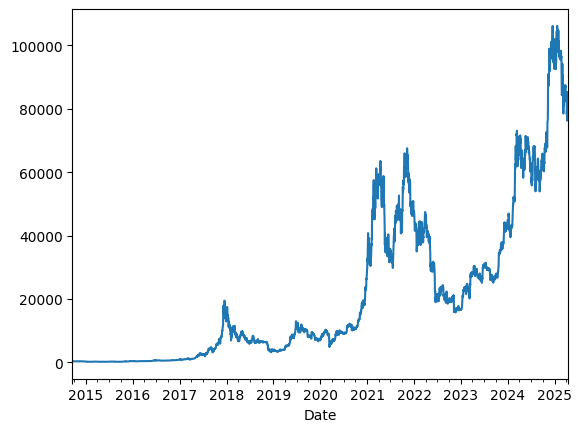

#### ETH-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2718.000000  2718.000000  2718.000000   2718.000000
mean      0.967703     0.983568     0.943347      0.963921
std       0.774309     0.786359     0.755140      0.770824
min       0.053261     0.053359     0.052627      0.053060
25%       0.179744     0.183984     0.175377      0.178922
50%       0.976225     0.987428     0.952658      0.974161
75%       1.557119     1.589071     1.512950      1.552250
max       3.039737     3.058430     2.997666      3.028518


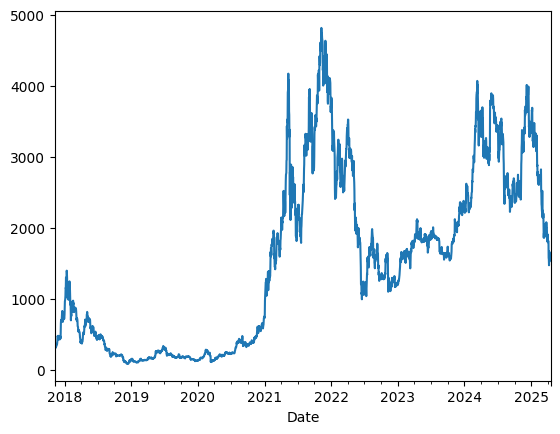

#### XRP-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2718.000000  2718.000000  2718.000000   2718.000000
mean      0.303987     0.312718     0.294368      0.304758
std       0.255797     0.266992     0.243916      0.256498
min       0.068003     0.070382     0.056252      0.067668
25%       0.155395     0.157982     0.152902      0.155675
50%       0.235393     0.238330     0.230576      0.235816
75%       0.317814     0.326033     0.307725      0.319025
max       1.627706     1.840606     1.554998      1.636911


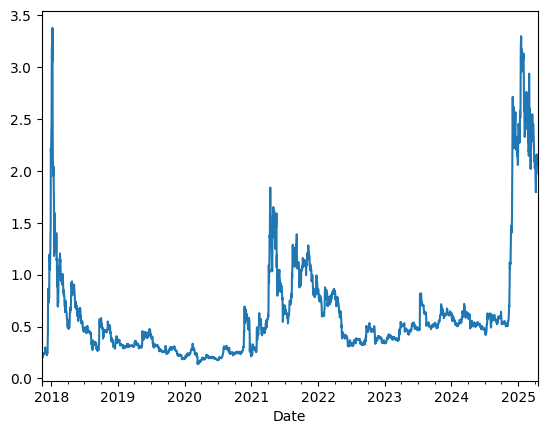

#### BNB-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2718.000000  2718.000000  2718.000000   2718.000000
mean      0.398931     0.405324     0.389948      0.398176
std       0.377812     0.383337     0.369669      0.376824
min       0.002561     0.002657     0.002490      0.002552
25%       0.029003     0.029424     0.028288      0.028941
50%       0.405702     0.408269     0.396752      0.404902
75%       0.661885     0.677927     0.641559      0.661140
max       1.273772     1.331647     1.244536      1.267858


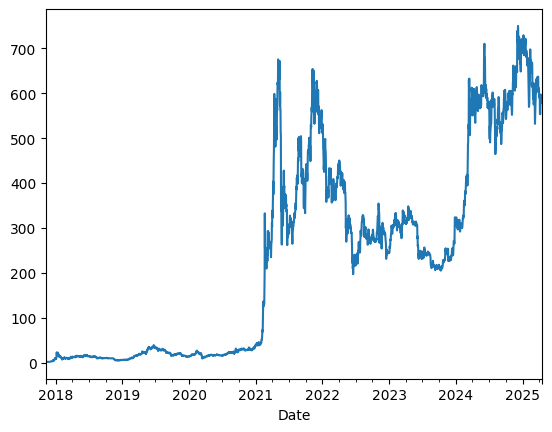

#### SOL-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  1835.000000  1835.000000  1835.000000   1835.000000
mean      0.552706     0.570009     0.539083      0.555722
std       0.526420     0.540930     0.514247      0.528641
min       0.003811     0.004120     0.003810      0.003843
25%       0.141741     0.144113     0.140097      0.142722
50%       0.284271     0.295025     0.269670      0.286792
75%       1.022233     1.052097     0.999099      1.027039
max       1.944056     2.166316     1.909580      1.953181


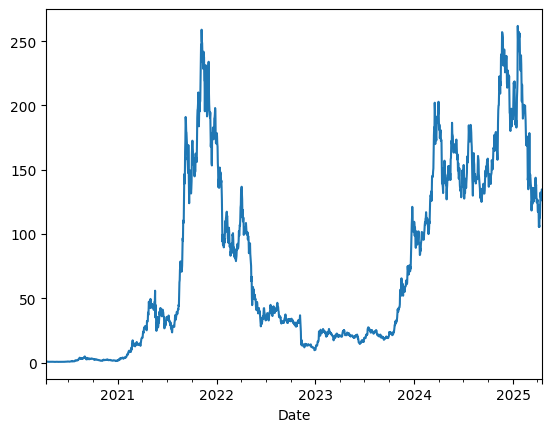

#### DOGE-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2718.000000  2718.000000  2718.000000   2718.000000
mean      0.537418     0.552344     0.519086      0.531451
std       0.655338     0.684762     0.621925      0.647806
min       0.006716     0.007621     0.006516      0.006586
25%       0.018672     0.018861     0.018282      0.018456
50%       0.403628     0.403203     0.400438      0.399331
75%       0.803444     0.817239     0.790405      0.794502
max       4.416313     4.645506     3.954947      4.344591


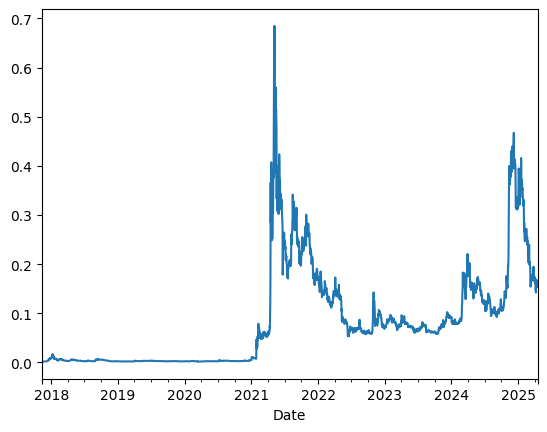

#### TRX-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2718.000000  2718.000000  2718.000000   2718.000000
mean      0.285896     0.294121     0.287037      0.295628
std       0.232835     0.239461     0.234194      0.240728
min       0.007244     0.008095     0.007024      0.007433
25%       0.102385     0.105319     0.102510      0.105892
50%       0.249575     0.255133     0.253398      0.257751
75%       0.374618     0.386328     0.375153      0.388006
max       1.719531     1.778206     1.349712      1.775766


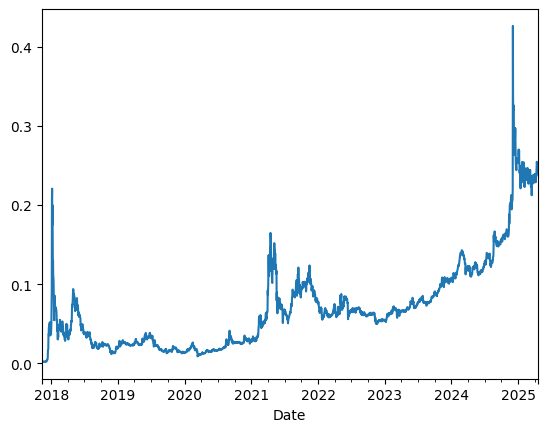

#### ADA-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2718.000000  2718.000000  2718.000000   2718.000000
mean      0.792484     0.804630     0.765384      0.778758
std       0.864818     0.880729     0.832104      0.849468
min       0.038867     0.041172     0.031301      0.038188
25%       0.147922     0.149354     0.143305      0.145220
50%       0.557743     0.560616     0.541568      0.548002
75%       1.003445     1.017944     0.961799      0.985594
max       4.813185     4.909049     4.757551      4.730676


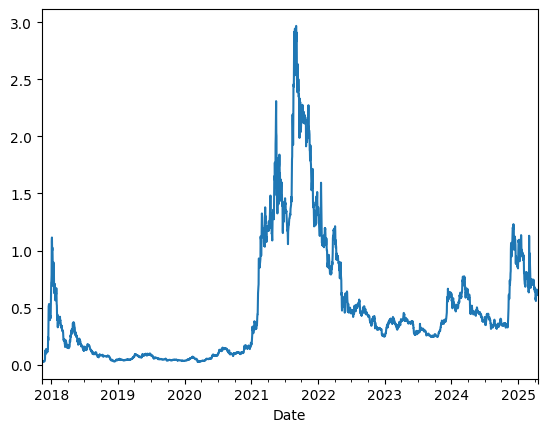

#### LEO-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2160.000000  2160.000000  2160.000000   2160.000000
mean      0.407296     0.407019     0.403044      0.401108
std       0.254355     0.253316     0.251892      0.250439
min       0.089989     0.089254     0.089218      0.088515
25%       0.148956     0.146796     0.148662      0.146543
50%       0.390021     0.390152     0.387425      0.383853
75%       0.585482     0.586106     0.576774      0.576275
max       1.096104     1.081487     1.086559      1.078231


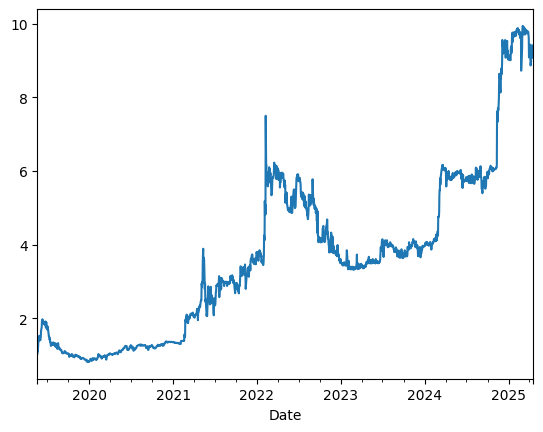

#### LINK-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2718.000000  2718.000000  2718.000000   2718.000000
mean      0.807760     0.828836     0.778214      0.805187
std       0.740024     0.764458     0.704889      0.737210
min       0.011772     0.013086     0.011111      0.011563
25%       0.170845     0.175805     0.165177      0.170436
50%       0.583429     0.591602     0.571984      0.581897
75%       1.213737     1.238991     1.171255      1.209521
max       4.173955     4.161159     3.763428      4.155119


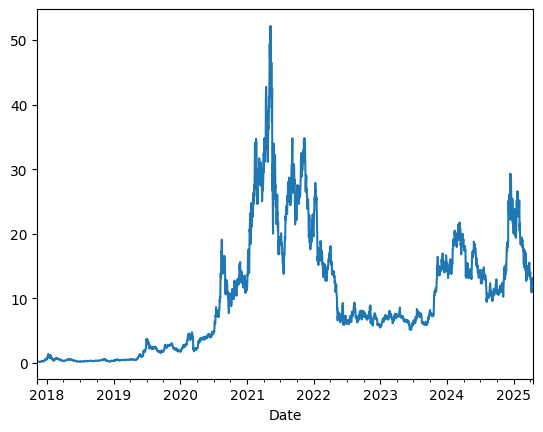

#### AVAX-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  1672.000000  1672.000000  1672.000000   1672.000000
mean      1.627865     1.680940     1.567625      1.625459
std       1.285534     1.334888     1.231690      1.283385
min       0.152601     0.152189     0.147826      0.152363
25%       0.765230     0.773370     0.740160      0.766362
50%       1.234533     1.265522     1.179578      1.232515
75%       1.965751     2.041451     1.902313      1.962081
max       7.083827     7.569174     6.689041      7.053158


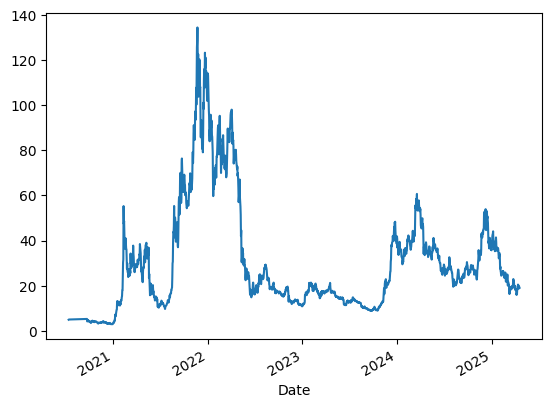

#### XLM-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2718.000000  2718.000000  2718.000000   2718.000000
mean      0.747600     0.762943     0.716730      0.745464
std       0.536524     0.561105     0.499704      0.534687
min       0.117521     0.130766     0.115255      0.117423
25%       0.378977     0.378669     0.372221      0.377766
50%       0.495550     0.496756     0.484828      0.494077
75%       1.029800     1.056520     0.993641      1.026117
max       3.730235     3.837492     2.842656      3.734201


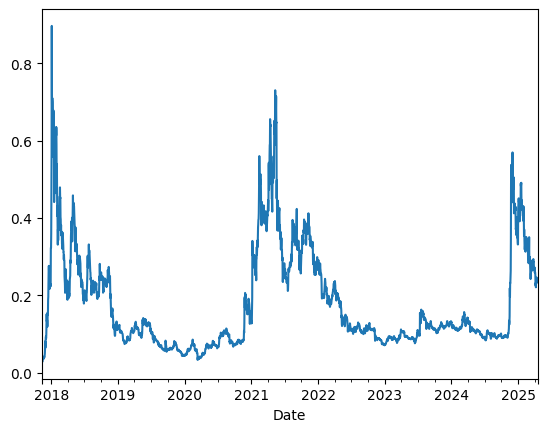

#### TON-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  1694.000000  1694.000000  1694.000000   1694.000000
mean      7.532964     1.910094     7.108883      1.962997
std       7.212490     1.866639     6.619643      1.876865
min       0.054039     0.018512     0.003418      0.014102
25%       3.269860     0.807605     3.175789      0.854404
50%       4.913126     1.223718     4.754019      1.281407
75%       8.887087     2.212874     8.532805      2.319140
max      57.215749    16.807397    53.188158     14.952430


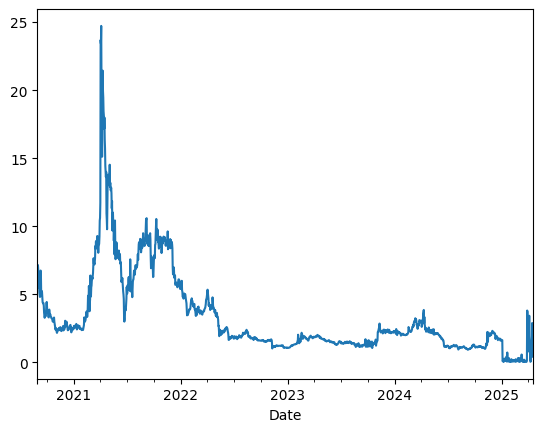

#### SHIB-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  1464.000000  1464.000000  1464.000000   1681.000000
mean      1.302539     1.363673     1.243454      1.134692
std       0.827213     0.892975     0.762251      0.886185
min       0.000000     0.083333     0.000000      0.000000
25%       0.750000     0.750000     0.666667      0.666667
50%       1.000000     1.000000     1.000000      0.916667
75%       1.750000     1.833333     1.666667      1.583333
max       6.583333     7.333333     5.583333      6.666666


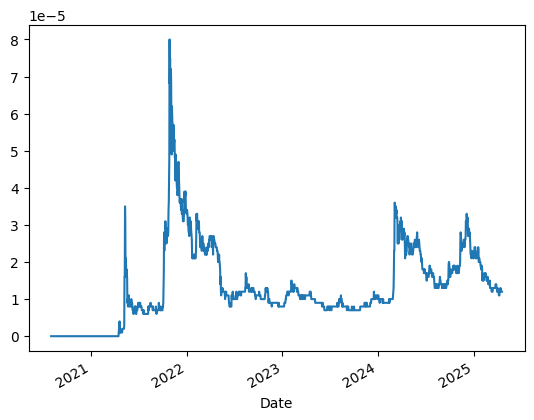

#### HBAR-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2041.000000  2041.000000  2041.000000   2041.000000
mean      0.715927     0.733753     0.683865      0.705305
std       0.632062     0.655106     0.597159      0.621879
min       0.061728     0.064053     0.061785      0.061057
25%       0.288948     0.290543     0.282017      0.285029
50%       0.402144     0.409751     0.389455      0.396730
75%       1.116837     1.137390     1.053559      1.095547
max       3.103415     3.423622     2.851765      3.064491


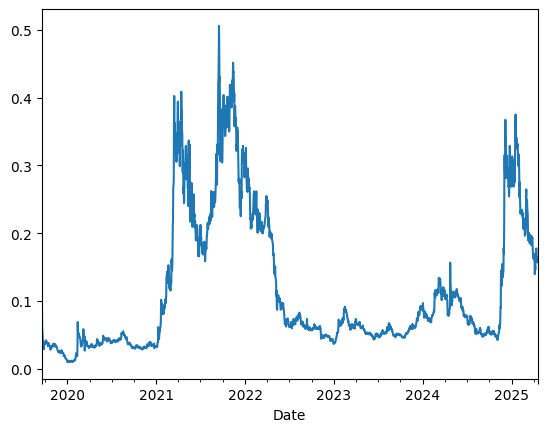

#### SUI-USD ####
       open_scaled  high_scaled  low_scaled  close_scaled
count   810.000000   810.000000  810.000000    810.000000
mean     15.401551    20.940312   14.941036     15.364102
std      10.006739   141.012406    9.667149     10.002876
min       0.063333     0.106667    0.000000      0.063333
25%      11.277499    11.616666   11.133333     11.266666
50%      13.259999    13.496666   12.985000     13.254999
75%      19.343332    20.211666   18.867499     19.331665
max      63.633332  4017.936595   45.616665     63.643328


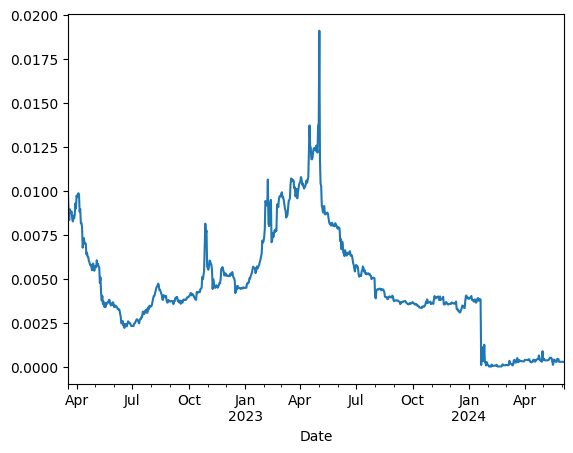

#### BCH-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2718.000000  2718.000000  2718.000000   2718.000000
mean      1.268809     1.280281     1.230566      1.260323
std       1.163991     1.213161     1.086499      1.155754
min       0.232168     0.240958     0.229034      0.230706
25%       0.666648     0.659539     0.658817      0.662159
50%       0.941587     0.939879     0.927191      0.935274
75%       1.453823     1.462201     1.422563      1.443041
max      11.729809    12.639315     9.268146     11.698646


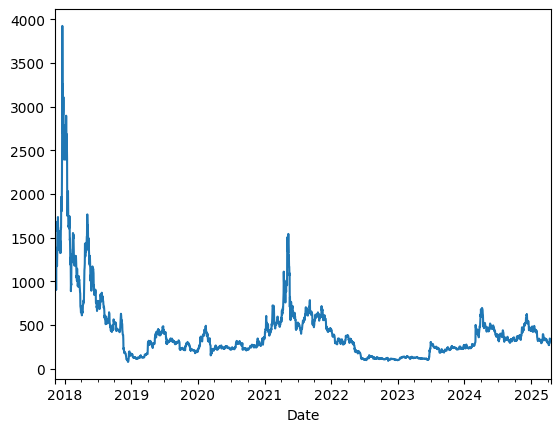

#### HYPE-USD ####
        open_scaled   high_scaled    low_scaled  close_scaled
count  1.324000e+03  1.324000e+03  1.324000e+03  1.324000e+03
mean   8.400476e+04  8.951584e+04  7.746468e+04  8.373753e+04
std    2.292549e+05  2.395613e+05  2.156006e+05  2.291482e+05
min    4.000000e-01  4.000000e-01  2.000000e-01  4.000000e-01
25%    3.560000e+01  3.800000e+01  3.070000e+01  3.495000e+01
50%    8.841000e+02  9.916000e+02  7.810000e+02  8.746000e+02
75%    3.526720e+04  3.959895e+04  3.044500e+04  3.522225e+04
max    1.190597e+06  1.200020e+06  1.154709e+06  1.190587e+06


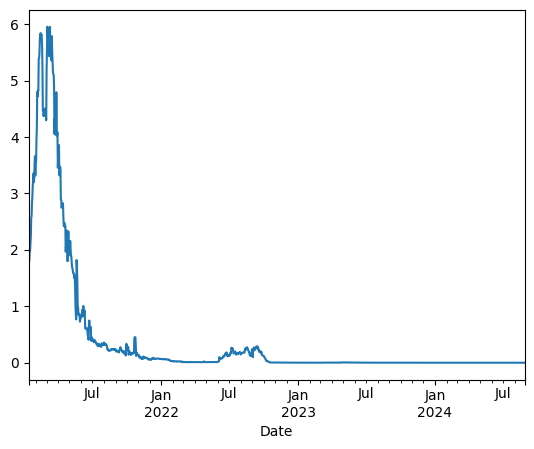

#### DOT-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  1703.000000  1703.000000  1703.000000   1703.000000
mean      3.302576     3.341954     3.161276      3.259274
std       3.003407     3.062097     2.842800      2.963651
min       0.767889     0.823369     0.744647      0.781562
25%       1.415961     1.408372     1.382038      1.396363
50%       1.855377     1.851463     1.806344      1.831167
75%       4.480497     4.561279     4.207656      4.418439
max      14.840115    14.714928    14.449601     14.647487


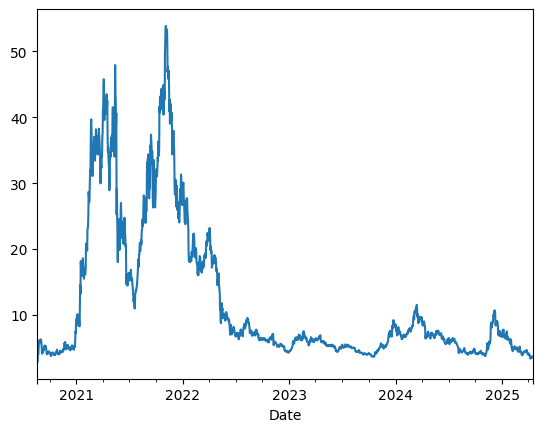

#### LTC-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  3867.000000  3867.000000  3867.000000   3867.000000
mean      0.940633     0.947918     0.906597      0.927013
std       0.809369     0.826006     0.767700      0.797086
min       0.015400     0.017469     0.014917      0.015226
25%       0.317717     0.331257     0.306864      0.313107
50%       0.835673     0.834631     0.815634      0.823511
75%       1.251304     1.243438     1.217318      1.233157
max       5.179593     5.364178     4.624792      5.085678


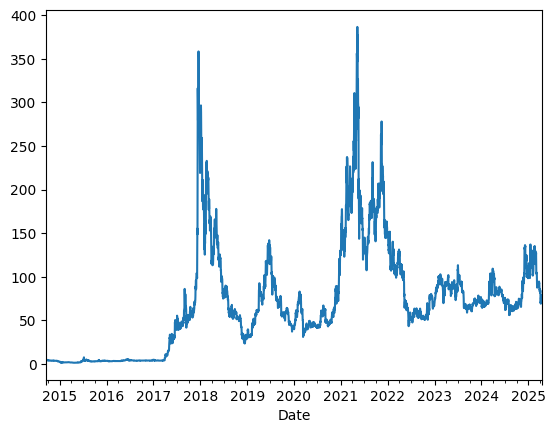

#### BGB-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  1360.000000  1360.000000  1360.000000   1360.000000
mean      0.213857     0.219111     0.209037      0.213232
std       0.344292     0.355607     0.333082      0.342747
min       0.013811     0.013858     0.013438      0.013724
25%       0.038530     0.039257     0.037623      0.038388
50%       0.100551     0.101158     0.100100      0.099927
75%       0.227888     0.231456     0.223386      0.226787
max       1.850193     1.919972     1.683356      1.838525


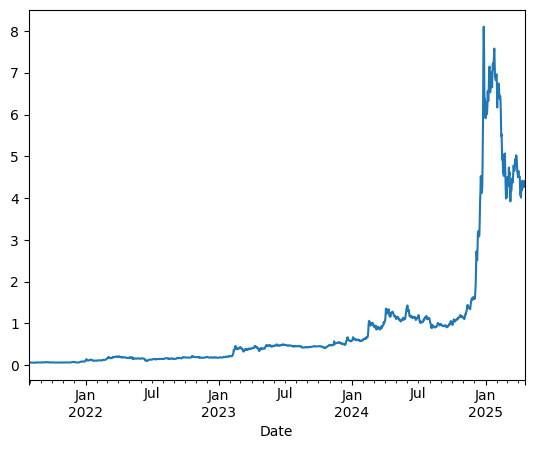

#### PI-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2503.000000  2503.000000  2503.000000   2503.000000
mean      4.809989     5.148791     4.478811      4.776936
std       7.650661     8.242745     6.986510      7.493055
min       0.149756     0.160000     0.135122      0.149756
25%       1.639268     1.733415     1.560488      1.641463
50%       2.566341     2.739024     2.448780      2.565854
75%       4.830000     5.250976     4.485122      4.815854
max     100.438536   108.216099    91.869271     99.937559


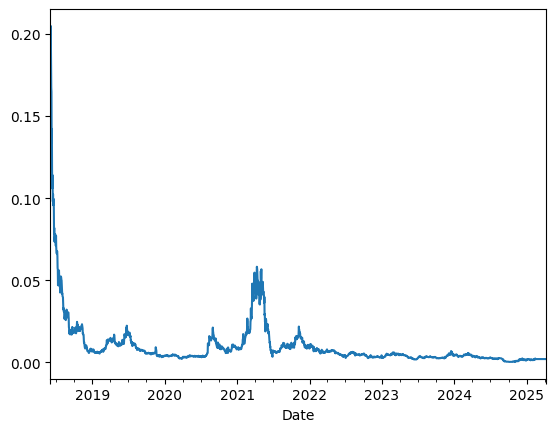

#### XMR-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2718.000000  2718.000000  2718.000000   2718.000000
mean      0.709130     0.722658     0.689907      0.711762
std       0.343103     0.356301     0.325580      0.344177
min       0.152669     0.166771     0.124308      0.152880
25%       0.445289     0.457685     0.432449      0.446765
50%       0.693714     0.697894     0.685141      0.696229
75%       0.874364     0.897547     0.845794      0.877801
max       2.232076     2.355660     2.110567      2.239617


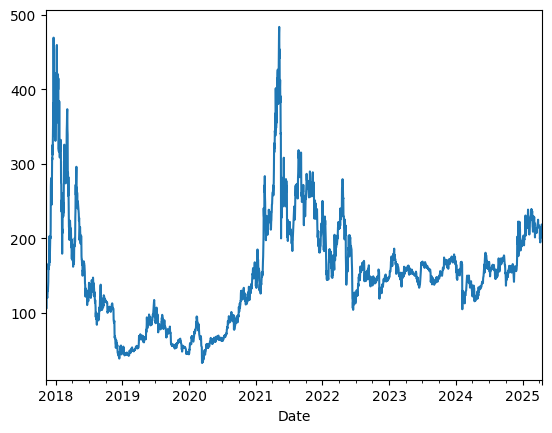

#### UNI-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2006.000000  2006.000000  2006.000000   2006.000000
mean      7.875652    11.670565     5.300589      7.852932
std     112.551675   184.283129    67.648330    112.548748
min       0.226994     0.233129     0.226994      0.226994
25%       0.785276     0.803681     0.762270      0.785276
50%       1.226994     1.279141     1.184049      1.226994
75%       2.108896     2.538344     1.746932      2.104294
max    3669.650181  6391.496579  2196.932440   3669.650181


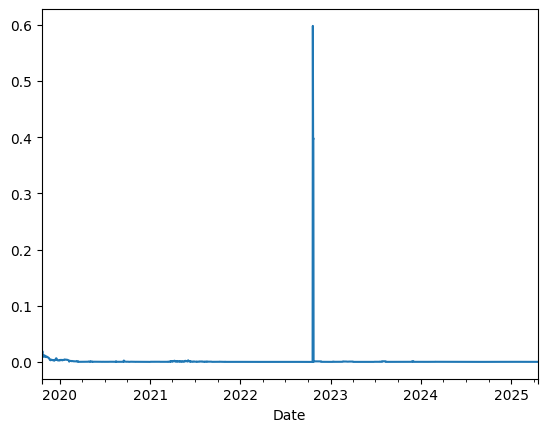

#### OKB-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2181.000000  2181.000000  2181.000000   2181.000000
mean      0.497102     0.509504     0.493416      0.501157
std       0.373580     0.380894     0.373005      0.376339
min       0.026482     0.026965     0.025233      0.026647
25%       0.115651     0.118291     0.114390      0.116846
50%       0.398158     0.411458     0.390427      0.401275
75%       0.852155     0.864410     0.859023      0.858939
max       1.431201     1.456234     1.337199      1.441678


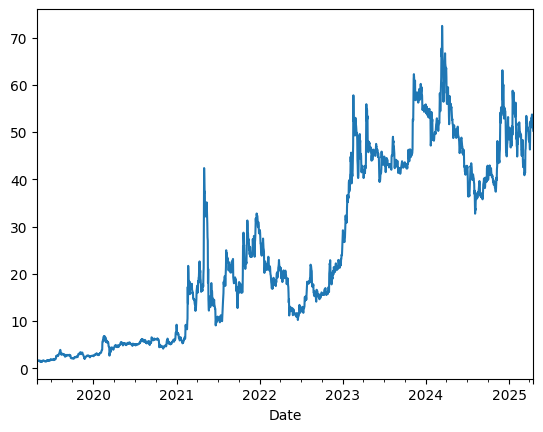

#### PEPE-USD ####
       open_scaled  high_scaled  low_scaled  close_scaled
count   119.000000   119.000000  119.000000    119.000000
mean      3.323529     3.663865    2.502801      2.802521
std       7.178623     8.284858    3.513023      4.631677
min       0.833333     1.000000    0.833333      0.833333
25%       1.000000     1.000000    1.000000      1.000000
50%       1.666667     1.666667    1.500000      1.500000
75%       3.666667     3.916667    3.083333      3.333333
max      62.666666    73.499999   32.999998     44.833334


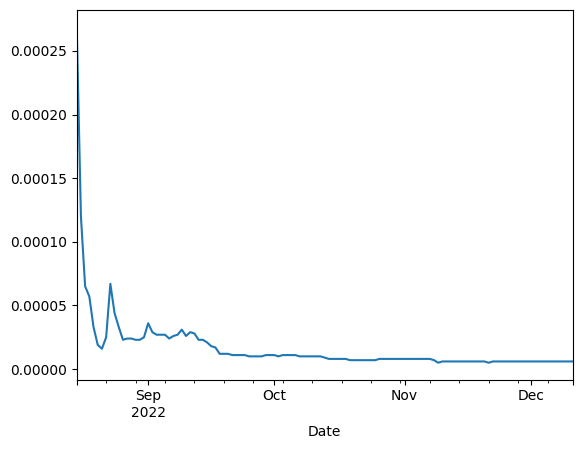

#### APT-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  1244.000000  1244.000000  1244.000000   1244.000000
mean     73.210958    76.028624    69.143535     71.438722
std     223.052224   234.173149   203.734393    214.869702
min       0.955882     0.977941     0.955882      0.955882
25%       1.948529     2.080882     1.656250      1.860294
50%       7.338235     7.621323     7.257352      7.330882
75%      28.042279    28.999999    27.391543     27.895220
max    2198.735323  2450.617535  1991.418977   2198.455926


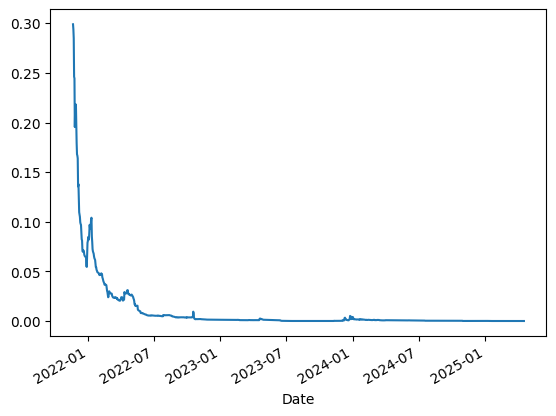

#### GT-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2063.000000  2063.000000  2063.000000   2063.000000
mean      0.223732     0.228171     0.219724      0.224684
std       0.214155     0.219034     0.209751      0.215291
min       0.014292     0.015348     0.011981      0.014325
25%       0.032090     0.032259     0.031769      0.032169
50%       0.191358     0.193422     0.190076      0.191832
75%       0.287556     0.291673     0.282514      0.288233
max       1.130272     1.149284     1.111327      1.132915


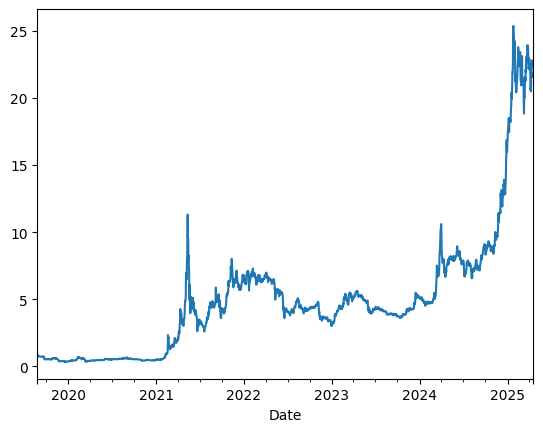

#### ONDO-USD ####
       open_scaled  high_scaled  low_scaled  close_scaled
count   457.000000   457.000000  457.000000    457.000000
mean      1.102245     1.146196    1.054904      1.100640
std       0.443009     0.460993    0.423585      0.439684
min       0.195407     0.259886    0.101542      0.240425
25%       0.848778     0.874915    0.814497      0.846786
50%       1.014194     1.055677    0.982326      1.011059
75%       1.409745     1.457669    1.348976      1.405496
max       2.463401     2.560021    2.409057      2.455797


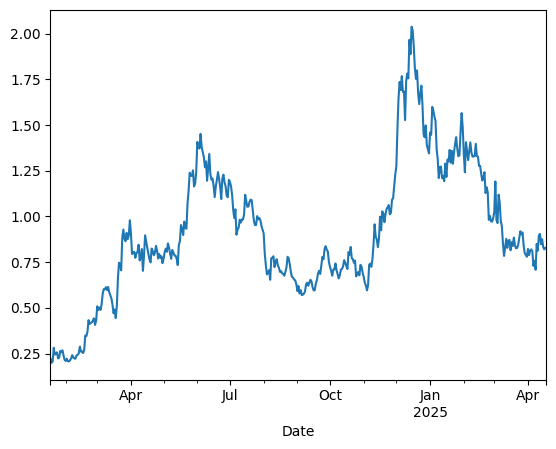

#### NEAR-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  1648.000000  1648.000000  1648.000000   1648.000000
mean      2.252931     2.321558     2.160676      2.244510
std       1.713767     1.776106     1.631429      1.706806
min       0.260801     0.270108     0.259421      0.259850
25%       0.964503     0.981087     0.943670      0.962858
50%       1.790430     1.832331     1.731429      1.783903
75%       2.908418     3.001177     2.785797      2.900553
max       9.852445     9.773733     9.419685      9.825617


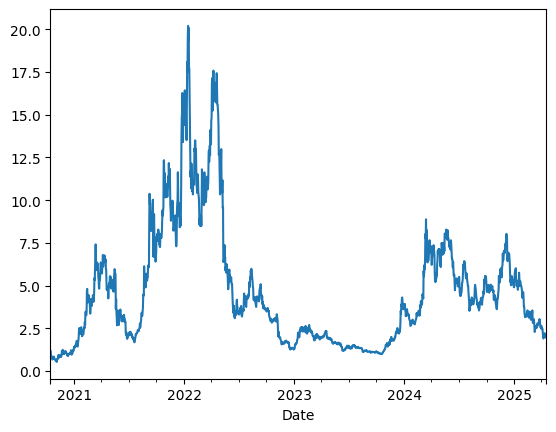

#### ETC-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2718.000000  2718.000000  2718.000000   2718.000000
mean      1.355390     1.365453     1.302217      1.322937
std       1.017304     1.053972     0.954104      0.992718
min       0.230689     0.239030     0.220166      0.225002
25%       0.491823     0.492411     0.473253      0.480082
50%       1.212827     1.197620     1.188184      1.184145
75%       1.764220     1.764413     1.703875      1.722271
max       8.873477    11.314199     7.605777      8.689474


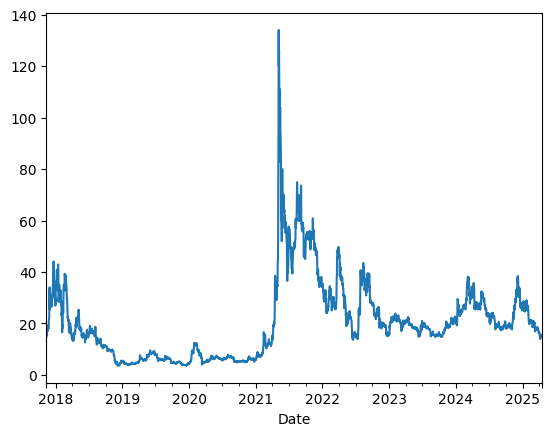

#### ICP-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  1440.000000  1440.000000  1440.000000   1440.000000
mean      3.703807     3.970221     3.474272      3.674415
std       6.204447     7.998733     5.388126      6.151115
min       0.000000     0.610721     0.000000      0.611076
25%       1.122405     1.134224     1.092542      1.113327
50%       1.719095     1.743449     1.680334      1.703697
75%       3.431756     3.512731     3.339417      3.404151
max      90.994571   156.140285    74.099820     90.234556


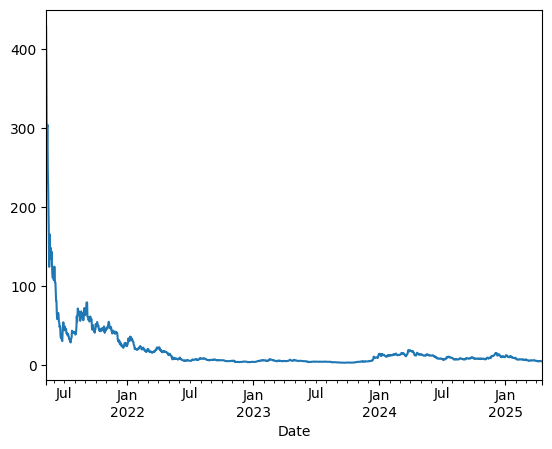

#### MNT-USD ####
       open_scaled  high_scaled  low_scaled  close_scaled
count   468.000000   468.000000  468.000000    468.000000
mean      1.839357     2.418016    1.232421      1.394774
std      13.431682    13.817606    9.270862      9.387543
min       0.290571     0.320464    0.268664      0.290571
25%       0.637338     0.778641    0.452393      0.637385
50%       0.886480     0.996371    0.778641      0.887518
75%       1.084741     1.263614    0.939292      1.079194
max     209.216287   211.286719  200.182188    201.986837


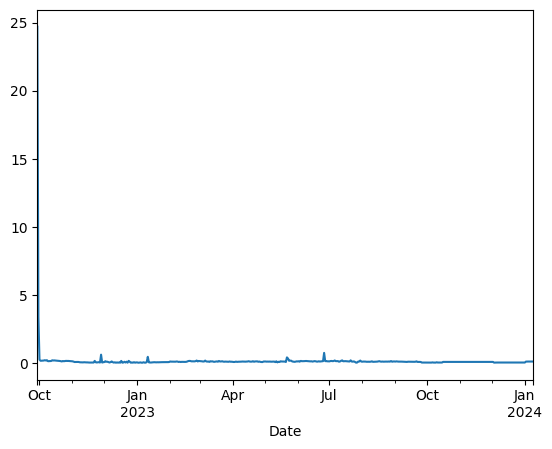

#### CRO-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2318.000000  2318.000000  2318.000000   2318.000000
mean      1.487412     1.528771     1.442289      1.483206
std       1.390641     1.443030     1.333661      1.385523
min       0.145773     0.147848     0.138580      0.144974
25%       0.724468     0.739896     0.710674      0.722733
50%       1.040925     1.067132     1.015092      1.037662
75%       1.717655     1.755739     1.680876      1.713186
max      10.775733    11.504769    10.132282     10.760034


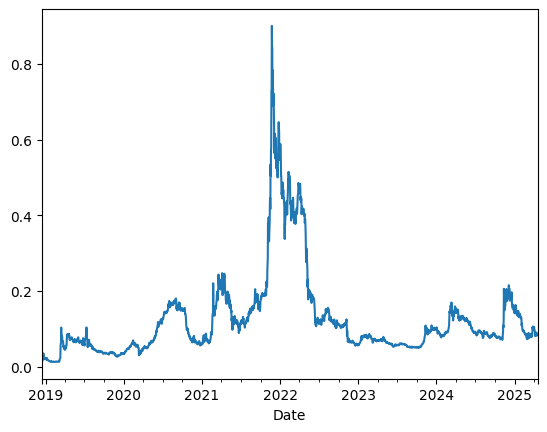

#### AAVE-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  1660.000000  1660.000000  1660.000000   1660.000000
mean      1.151651     1.187872     1.108346      1.153770
std       0.818357     0.855944     0.776368      0.818932
min       0.000000     0.003668     0.000000      0.003728
25%       0.564973     0.573134     0.547320      0.565939
50%       0.746780     0.763012     0.725224      0.748317
75%       1.608460     1.692918     1.519185      1.611582
max       4.534887     4.734733     4.118527      4.562660


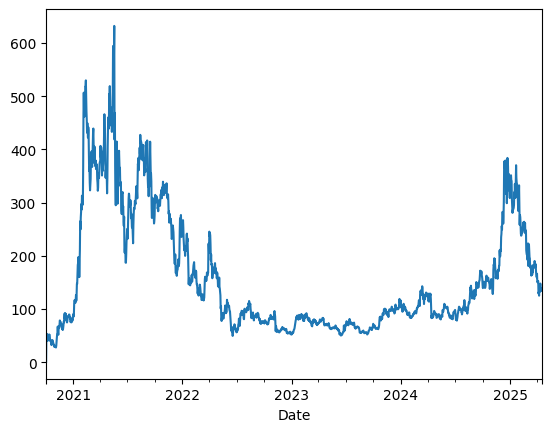

#### RENDER-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  1772.000000  1772.000000  1772.000000   1772.000000
mean      0.679589     0.703962     0.667137      0.700743
std       0.704165     0.725682     0.692700      0.725341
min       0.009677     0.013308     0.009454      0.012001
25%       0.130039     0.137587     0.128622      0.133961
50%       0.402914     0.423763     0.398252      0.415934
75%       1.067485     1.114467     1.042678      1.100281
max       3.274762     3.327072     2.994771      3.374322


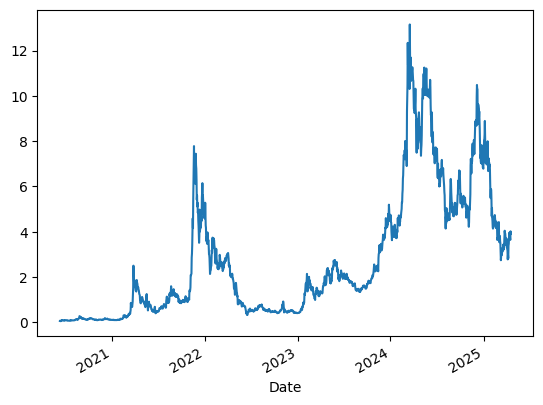

#### KAS-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  1053.000000  1053.000000  1053.000000   1053.000000
mean      0.976778     0.992129     0.950133      0.976704
std       0.818392     0.826926     0.798177      0.816903
min       0.002409     0.002421     0.002255      0.002406
25%       0.108508     0.112065     0.103096      0.109539
50%       0.793091     0.843517     0.762826      0.810552
75%       1.725046     1.770284     1.682914      1.723151
max       2.691286     2.659065     2.589899      2.688329


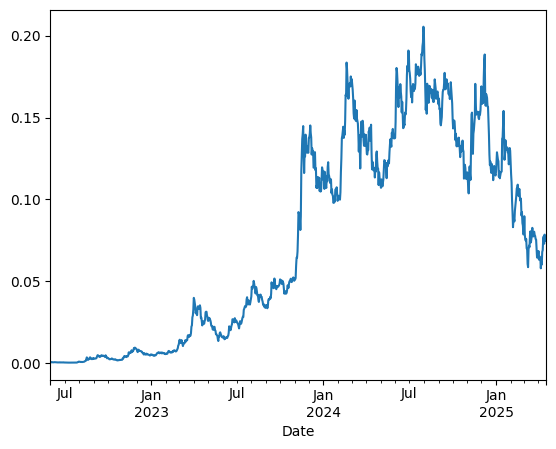

#### VET-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2451.000000  2451.000000  2451.000000   2451.000000
mean      1.462931     1.484935     1.405078      1.437186
std       1.638941     1.691378     1.542853      1.610409
min       0.099200     0.105317     0.074515      0.098136
25%       0.447017     0.447937     0.437231      0.438633
50%       0.972762     0.967009     0.954083      0.955507
75%       1.585120     1.602060     1.557685      1.557138
max      11.124067    11.843514     9.875971     10.988779


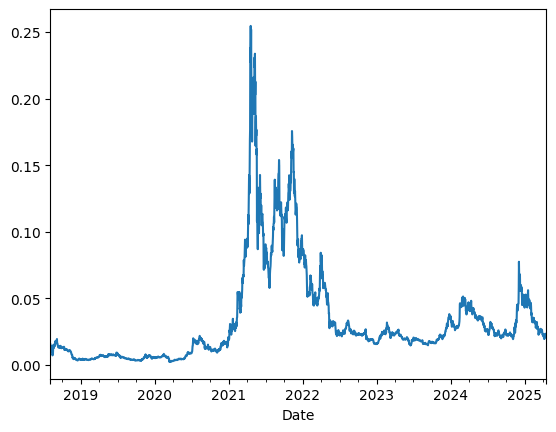

#### POL-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  1181.000000  1181.000000  1181.000000   1181.000000
mean      9.752245    10.455614     9.270247      9.751610
std      12.203388    13.290727    11.496077     12.207383
min       0.665453     0.671521     0.000000      0.664118
25%       1.875258     1.967358     1.820896      1.875501
50%       3.181168     3.365611     3.033127      3.178983
75%      13.544230    14.802209    12.588157     13.543745
max      75.818833    82.763870    65.923434     75.820532


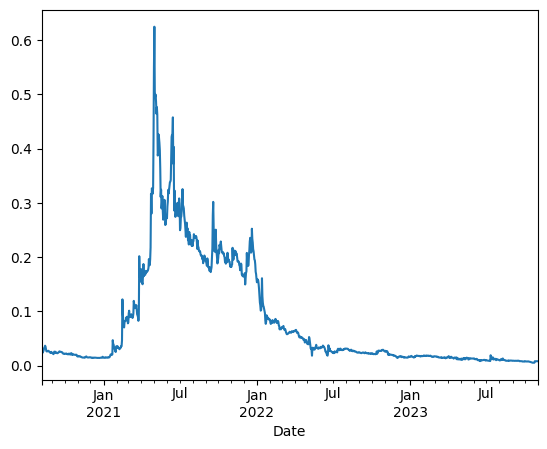

#### TRUMP-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2525.000000  2525.000000  2525.000000   2525.000000
mean    129.928151   141.447415   109.485071    122.100870
std     264.267498   306.013812   230.924242    247.991774
min       0.077586     0.343243 -3498.718300      0.072973
25%       9.905172    10.951352     8.916667      9.316216
50%      51.741381    56.354053    46.502874     48.643246
75%     125.571839   135.245952   110.385061    117.240546
max    2428.163732  4512.567525  1788.686740   2207.272957


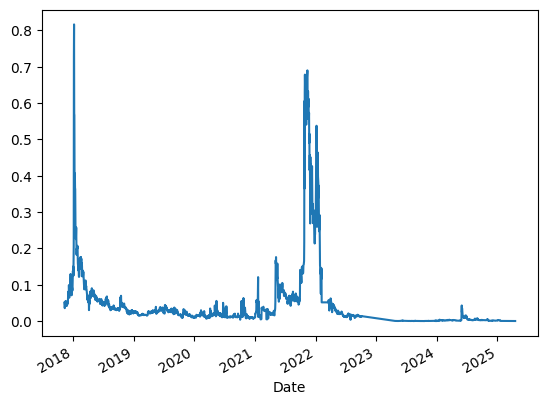

#### ALGO-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2129.000000  2129.000000  2129.000000   2129.000000
mean      2.558311     2.610166     2.440376      2.513613
std       2.503622     2.581167     2.346327      2.446752
min       0.474321     0.470025     0.472465      0.467457
25%       1.006149     1.009930     0.980716      0.991679
50%       1.490990     1.519988     1.432094      1.464162
75%       3.109151     3.241026     2.984183      3.064437
max      17.562474    17.071729    12.899453     16.902022


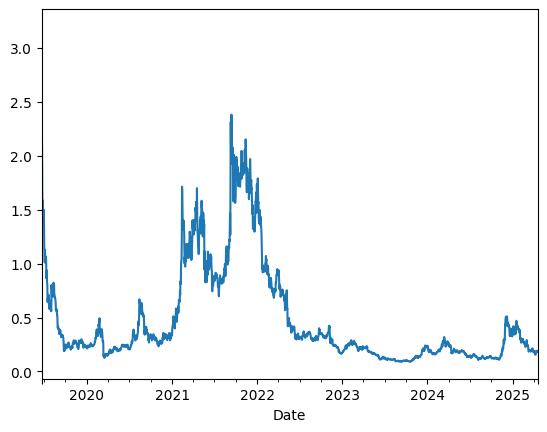

#### FIL-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2684.000000  2684.000000  2684.000000   2684.000000
mean      6.967465     7.028942     6.609604      6.759898
std      11.105151    11.248355    10.562187     10.779515
min       0.950289     0.970167     0.771865      0.922273
25%       1.747504     1.773959     1.624993      1.693653
50%       2.374129     2.388955     2.256403      2.301857
75%       7.702927     7.688465     7.351702      7.463509
max      80.311980    95.362246    77.097652     78.026877


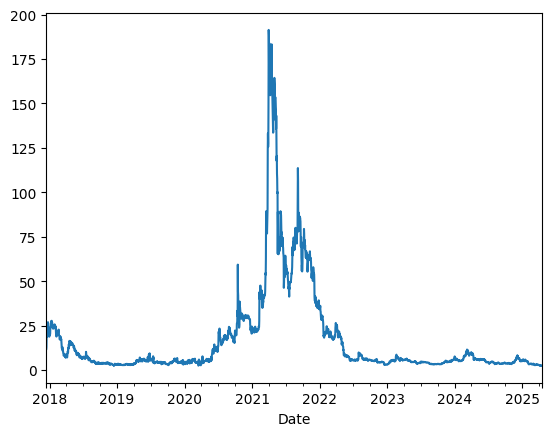

#### ATOM-USD ####
       open_scaled  high_scaled   low_scaled  close_scaled
count  2228.000000  2228.000000  2228.000000   2228.000000
mean      2.581086     2.623155     2.483639      2.571450
std       2.059615     2.116539     1.954799      2.052284
min       0.402011     0.429803     0.277428      0.399825
25%       1.127722     1.141437     1.099507      1.122971
50%       2.044360     2.048718     1.984812      2.037059
75%       2.957513     2.987304     2.846444      2.946859
max      10.773416    10.592728     9.621568     10.798746


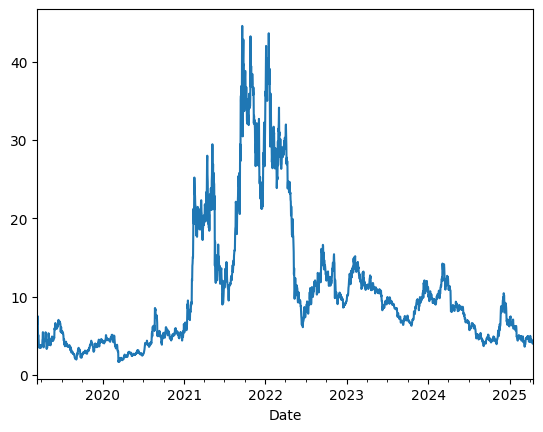

In [30]:
for symbol in crypto_prices_data['ticker'].unique():
    print(f"#### {symbol} ####")
    one_crypto_data = crypto_prices_data[crypto_prices_data['ticker'] == f'{symbol}']
    print(one_crypto_data[[x for x in one_crypto_data.columns if 'scaled' in x]].describe())
    one_crypto_data['close'].plot()
    plt.show()

In [88]:
crypto_total_market_cap['High'].max()

np.float64(3400752818778.344)

In [12]:
crypto_total_market_cap[crypto_total_market_cap['Open'] > crypto_total_market_cap['Close']].shape[0]/crypto_total_market_cap.shape[0]

0.6858247422680412

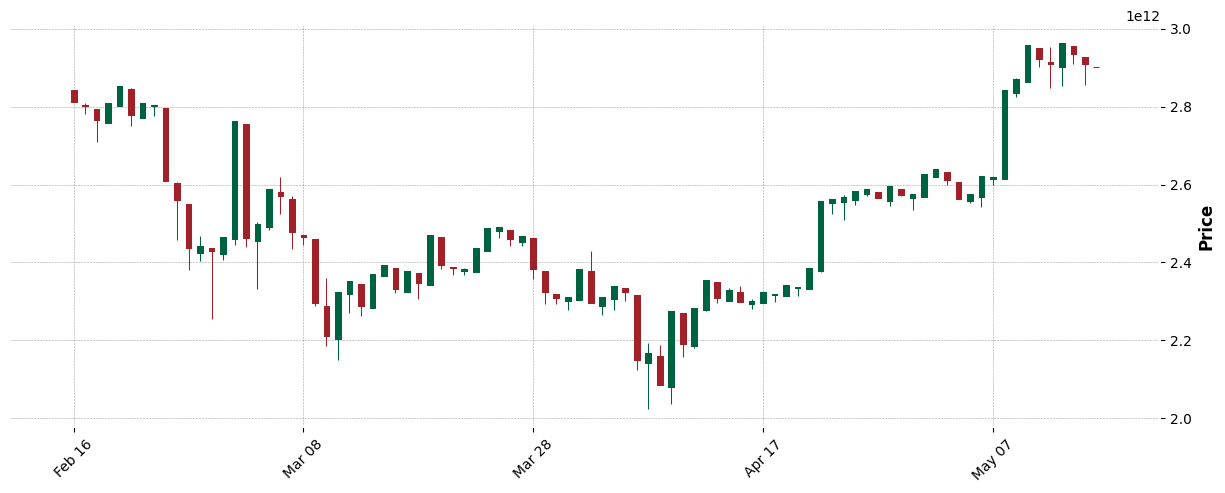

In [17]:
import mplfinance as mpf
crypto_total_market_cap.columns=['Open', 'High', 'Low', 'Close']
# Plot candlestick chart
mpf.plot(crypto_total_market_cap[-90:], type='candle', style='charles', figratio=(25, 9))

In [27]:
crypto_total_market_cap[crypto_total_market_cap == crypto_total_market_cap.max()]

Date
2021-02-26    6.079566e+11
dtype: float64

In [24]:
crypto_prices_data[crypto_prices_data['ticker'] == 'BTC-USD'][['open', 'high', 'low', 'close']]

,open,high,low,close
Date,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015
2014-09-18,456.859985,456.859985,413.104004,424.440002
2014-09-19,424.102997,427.834991,384.532013,394.795990
2014-09-20,394.673004,423.295990,389.882996,408.903992
2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...
2025-04-22,87521.875000,93817.382812,87084.531250,93441.890625
2025-04-23,93427.585938,94535.734375,91962.960938,93699.109375
2025-04-24,93692.398438,94016.195312,91696.710938,93943.796875


## TODO:
- plot FVGs, check how to paint them in mplfinance

In [18]:
btc_sample_prices = crypto_prices_data[(crypto_prices_data['ticker'] == 'BTC-USD')][['open', 'high', 'low', 'close']][-240:-120]

In [19]:
for col in ['open', 'high', 'low', 'close']:
    btc_sample_prices[f'{col}_previous'] = btc_sample_prices[col].shift(1)
    btc_sample_prices[f'{col}_following'] = btc_sample_prices[col].shift(-1)

In [20]:
btc_sample_prices['fvg_dist'] = btc_sample_prices['low_following'] - btc_sample_prices['high_previous'] 

In [22]:
btc_sample_prices

,open,high,low,close,open_previous,open_following,high_previous,high_following,low_previous,low_following,close_previous,close_following,fvg_dist
Date,,,,,,,,,,,,,
2024-09-19,61651.156250,63872.441406,61609.867188,62940.457031,NaN,62941.425781,NaN,64119.531250,NaN,62364.605469,NaN,63192.976562,NaN
2024-09-20,62941.425781,64119.531250,62364.605469,63192.976562,61651.156250,63184.339844,63872.441406,63543.359375,61609.867188,62783.105469,62940.457031,63394.839844,-1089.335938
2024-09-21,63184.339844,63543.359375,62783.105469,63394.839844,62941.425781,63396.804688,64119.531250,63993.421875,62364.605469,62440.726562,63192.976562,63648.710938,-1678.804688
2024-09-22,63396.804688,63993.421875,62440.726562,63648.710938,63184.339844,63643.101562,63543.359375,64733.558594,62783.105469,62628.078125,63394.839844,63329.800781,-915.281250
2024-09-23,63643.101562,64733.558594,62628.078125,63329.800781,63396.804688,63326.839844,63993.421875,64695.214844,62440.726562,62737.417969,63648.710938,64301.968750,-1256.003906
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-12,94565.726562,95367.539062,93712.507812,94488.437500,94700.835938,94488.890625,94977.687500,95837.000000,93840.046875,89260.101562,94566.593750,94516.523438,-5717.585938
2025-01-13,94488.890625,95837.000000,89260.101562,94516.523438,94565.726562,94519.007812,95367.539062,97352.664062,93712.507812,94322.156250,94488.437500,96534.046875,-1045.382812
2025-01-14,94519.007812,97352.664062,94322.156250,96534.046875,94488.890625,96534.046875,95837.000000,100697.234375,89260.101562,96501.640625,94516.523438,100504.492188,664.640625


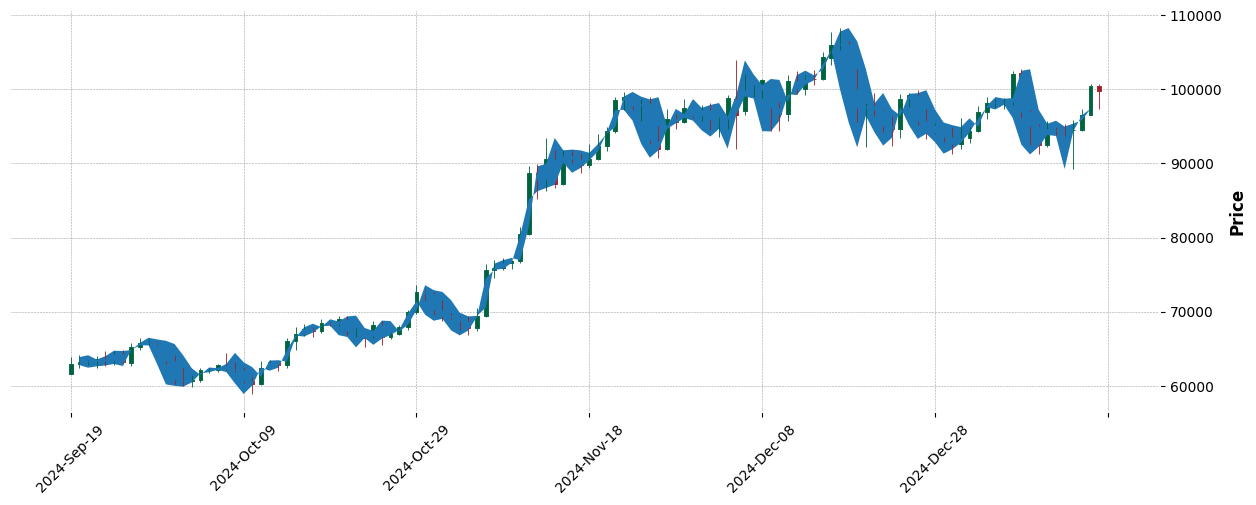

In [28]:
mpf.plot(
    btc_sample_prices, 
    type='candle', 
    style='charles', 
    figratio=(25, 9),
    addplot=
    #fill_between=dict(y1=btc_sample_prices['high_previous'].values,y2=btc_sample_prices['low_following'].values)
)

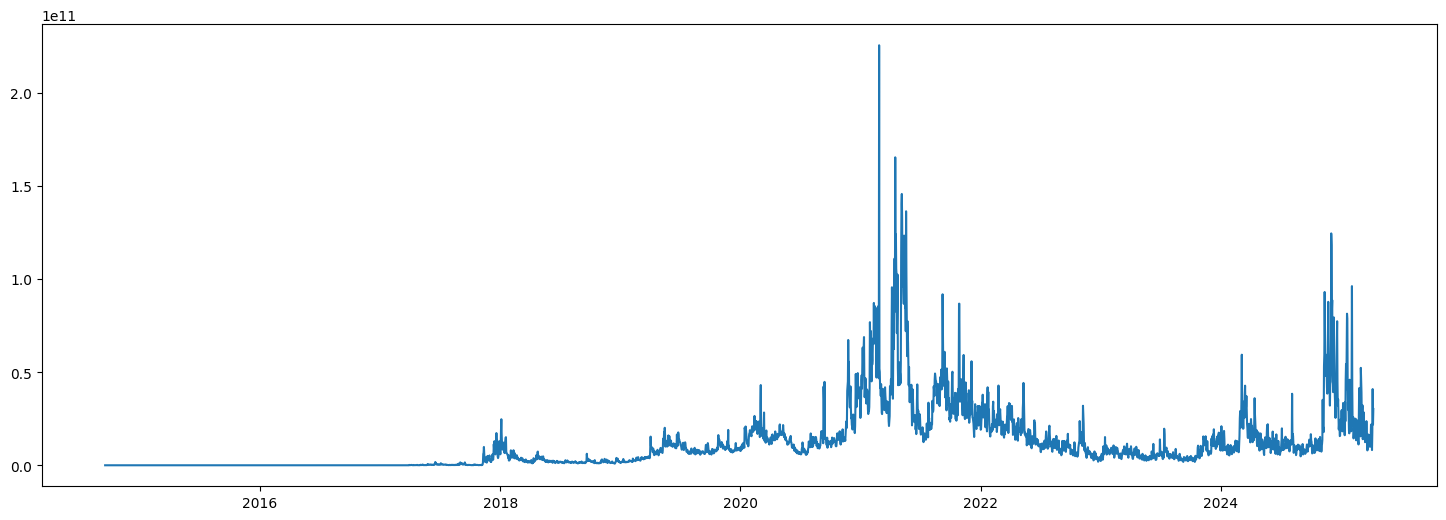

In [21]:
plt.figure(figsize=(18,6))
plt.plot(crypto_total_market_cap.index, crypto_total_market_cap.values)


In [48]:
import pandas as pd
import yfinance as yf
import mplfinance as mpf
import numpy as np

# Function to detect Fair Value Gaps
def detect_fvgs(df):
    fvgs = []
    for i in range(len(df) - 2):
        # Bullish FVG: Low of candle n+2 > High of candle n
        if df['low'].iloc[i + 2] > df['high'].iloc[i]:
            fvg = {
                'type': 'bullish',
                'start_date': df.index[i + 1],  # Middle candle
                'end_date': df.index[i + 2],    # End of gap
                'bottom': df['high'].iloc[i],   # Bottom of gap
                'top': df['low'].iloc[i + 2]    # Top of gap
            }
            fvgs.append(fvg)
        # Bearish FVG: High of candle n+2 < Low of candle n
        elif df['high'].iloc[i + 2] < df['low'].iloc[i]:
            fvg = {
                'type': 'bearish',
                'start_date': df.index[i + 1],
                'end_date': df.index[i + 2],
                'bottom': df['high'].iloc[i + 2],
                'top': df['low'].iloc[i]
            }
            fvgs.append(fvg)
    return fvgs

# Download stock data
ticker = "AAPL"
start_date = "2024-01-01"
end_date = "2024-06-30"
df = yf.download(ticker, start=start_date, end=end_date, interval="1d")
df.columns = ['close', 'high', 'low', 'open', 'volume']

# Detect FVGs
fvgs = detect_fvgs(df)

# Prepare fill_between for plotting FVGs
fb_plots = []
for fvg in fvgs:
    # Create a Series for the FVG price levels
    bottom = pd.Series(np.nan, index=df.index)
    top = pd.Series(np.nan, index=df.index)
    # Set values only for the FVG period
    mask = (df.index >= fvg['start_date']) & (df.index <= fvg['end_date'])
    bottom[mask] = fvg['bottom']
    top[mask] = fvg['top']
    # Define color based on FVG type
    color = 'green' if fvg['type'] == 'bullish' else 'red'
    # Add fill_between plot
    fb_plots.append(mpf.make_addplot(bottom, type='line', color=color, alpha=0.0))  # Invisible line for bottom
    fb_plots.append(mpf.make_addplot(top, type='line', color=color, alpha=0.0))      # Invisible line for top
    fb_plots.append({
        'type': 'fill_between',
        'data': (bottom, top),
        'color': color,
        'alpha': 0.2
    })

# Plot candlestick chart with FVGs
mpf.plot(
    df,
    type='candle',
    style='yahoo',
    title=f"{ticker} with Fair Value Gaps",
    ylabel='Price ($)',
    volume=True,
    addplot=fb_plots,
    figsize=(14, 8),
    show_nontrading=False
)


*********************100%***********************]  1 of 1 completed

KeyError: 'ax'

In [53]:
len(fb_plots)

123

In [52]:
for x in fb_plots:
    if 'ax' not in x.keys():
        print('ax not in x keys')

ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys
ax not in x keys


In [37]:
df['Low'].iloc[0 + 2].values[0]

np.float64(179.56501368920854)

In [45]:
df.columns = ['close', 'high', 'low', 'open', 'volume']

In [46]:
df

,close,high,low,open,volume
Date,,,,,
2024-01-02,184.290436,187.070083,182.553158,185.789453,82488700
2024-01-03,182.910522,184.528677,182.096477,182.880742,58414500
2024-01-04,180.587524,181.758939,179.565014,180.825770,71983600
2024-01-05,179.862854,181.431370,178.860202,180.666978,62303300
2024-01-08,184.210999,184.250716,180.180517,180.766224,59144500
...,...,...,...,...,...
2024-06-24,207.171143,211.709914,205.628355,206.753099,80727000
2024-06-25,208.096802,210.396046,207.638936,208.176416,56713900
2024-06-26,212.257339,213.859846,209.659488,210.515486,66213200
